In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy
import sklearn.datasets
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

# dgm_utils
from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data
from seminar6_utils import draw_distrib, plot_training_curves

OUTPUT_SEED = 0xBADBEEF

torch.manual_seed(OUTPUT_SEED)
np.random.seed(OUTPUT_SEED)

# <center>Deep Generative Models</center>
## <center>Seminar 6. Part 2</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>22.11.2022</center>


#### Digits dataset

In [3]:
def generate_digits_data(normalize=True):
    digits = load_digits()
    # print(digits)
    data, labels = digits['data'], digits['target']
    data = data.astype('float32')
    if normalize:
        data = data/16.
        data = (data - 0.5)/0.5
    count = len(data)
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

In [4]:
train_data, train_labels, test_data, test_labels = generate_digits_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


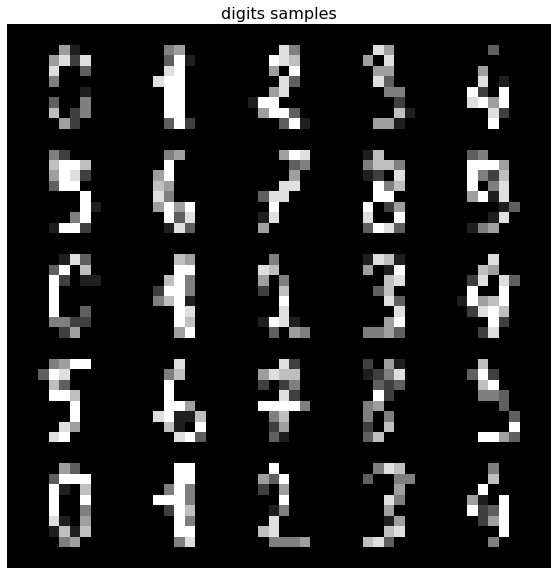

In [5]:
show_samples(train_data[:25].reshape(-1, 1, 8, 8), 'digits samples', figsize=(10, 10))

## IDF (integer discrete flows)

< image credits: [https://jmtomczak.github.io/blog/5/5_IDF.html](https://jmtomczak.github.io/blog/5/5_IDF.html) >

Recall the **Normalizing flows**:

<center><img src="pics/flows_how2.png" width=800 /></center>

**CoV** theorem:

$$
    p(x | \theta) = p_z(f(x)) \left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x} \right) \right\vert
$$

**Pitfalls of normalizing flows**:

1. Vast majority of data is discrete ($\Rightarrow$ *Dequantization* and *Discretization* to be applied)

2. $f$ must be diffeomorphism ($\Rightarrow$ toplogical and continuity issues come into play)

<center><img src="pics/flows_dequantization_issue.png" width=800 /></center>

3. Jacobian computation!

4. We want publications!

### Discrete flows

Let $\boldsymbol{x} \in \mathcal{X}^D$, $\mathcal{X}$ is a discrete space, e.g. $\mathcal{X} = \{ 0, 1 \}$ or $\mathcal{X} = \mathbb{Z}$.

**Change of variable** theorem:

$p(\boldsymbol{x} | \theta) = p_z(\boldsymbol{z} = f_{\theta}(\boldsymbol{x}))$ , $f : \mathcal{X}^D \rightarrow \mathcal{X}^D$ is an invertible transformation.

**Question**:

Let $\mathcal{X} = \{0, 1\}$ and $D = 2$. What can be the transformation $f$?

**Answer**:

$f$ is a *permutation* of elements in $\{0, 1\}^2$: 

<center><img src="pics/flow_discrete_finite.png" width=800 /></center>

**Question**:

Why does this fact limits the expressibility of discrete flows on $\{0, 1\}^2$?

**Answer**:

The prior $p_{z}$ should be nontrivial. In general, the factrorization does not hold:

$p_{z}(\boldsymbol{z}) \neq \prod\limits_{d = 1}^{2} p_{z_d}(z_d)$

**Question**: What to do?

### IDF (integer discrete flows) 

link to the [IDF_article](https://arxiv.org/pdf/1905.07376.pdf)

**Idea**: Model the desired distribution $\pi(x)$ with $\text{supp}(\pi) = \mathcal{X}^D$ in the **extended** space $\mathcal{X}_{\text{extended}}^D$, where $\mathcal{X}_{\text{extended}} = \mathbb{Z}$

<center><img src="pics/idf_transformation.png" width=800 /></center>

The latent space factorization $p_{z}(\boldsymbol{z}) = \prod\limits_{d = 1}^{2} p_{z_d}(z_d)$ holds true!

Lemma from the [IDF_philosophy_article](https://arxiv.org/pdf/2006.12459.pdf): 

<center><img src="pics/lemma_idf.png" width=1000 /></center>

**IDF** coupling:

$$
\begin{cases}\boldsymbol{z}_{1:d} = \boldsymbol{x}_{1:d} \\ \boldsymbol{z}_{d+1:D} = \boldsymbol{x}_{d+1:D} + \lfloor t_{\theta}(\boldsymbol{x}_{1:d}) \rceil\end{cases}
$$

**Question**: Can we use couplings similar to RealNVP?

**Question**: How to perform gradient backprop through round operator $\lfloor \cdot \rceil$

**Question**: How to model factorized latent distribution $p_z(\boldsymbol{z}) = \prod\limits_{d = 1}^{D} p_{z_i}(z_i)$?

**Answers**:

1. No, since RealNVP coupling has scale parameter.

2. `RoundStraightThroug` (will be considered later)

3. The authors of [IDF_article](https://arxiv.org/pdf/1905.07376.pdf) proposed to use discretized logistic distributions with learned $\text{mean}$ and $\text{scale}$ parameters:

    $$p_z(\boldsymbol{z}) = \prod\limits_{d = 1}^{D} \text{DiscretizedLogistic}(z_d | \mu_d, s_d)$$
    
    $$\text{DiscretizedLogistic}(z_d | \mu_d, s_d) = \text{CDF}_{\text{Logistic}}(z_d + 0.5 | \mu_d, s_d) - \text{CDF}_{\text{Logistic}}(z_d - 0.5 | \mu_d, s_d)$$
    
    <center><img src="pics/discretized_logistic.png" width=600 /></center>

    **Logistic distribution cdfs** (scaled and shifted sigmoids)

    <center><img src="pics/Logistic_cdf.png" width=600 /></center>

### IDF implementation

In [6]:
# Source: https://github.com/jornpeters/integer_discrete_flows
class RoundStraightThrough(torch.autograd.Function):

    def __init__(self):
        super().__init__()

    @staticmethod
    def forward(ctx, input):
        rounded = torch.round(input, out=None)
        return rounded

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

**Question**: What the difference between `sample` and `rsample` methods of a `torch.distribution`?

In [7]:
def Logistic(loc, scale):
    return TD.TransformedDistribution(
        TD.Uniform(torch.zeros_like(loc), torch.ones_like(loc)),
        [TD.SigmoidTransform().inv, TD.AffineTransform(loc, scale)]
    )

class DiscreteLearnableLogistic(nn.Module):

    @property
    def logistic(self):
        return Logistic(self.mean, self.scale)

    @property
    def scale(self):
        return self.log_scale.exp()

    def __init__(self, dim):
        super().__init__()
        self.mean = nn.Parameter(torch.zeros(dim))
        self.log_scale = nn.Parameter(torch.ones(dim))
        self.round = RoundStraightThrough.apply

    def rsample(self, shape):
        if isinstance(shape, int):
            shape = (shape,)
        cx = self.logistic.rsample(shape)
        return self.round(cx)

    def sample(self, shape):
        if isinstance(shape, int):
            shape = (shape,)
        return torch.round(self.logistic.sample(shape))

    def log_prob(self, x):
        logistic = self.logistic
        F_X_plus = logistic.cdf(x + 0.5) # (bs, dim)
        F_X_minus = logistic.cdf(x - 0.5) # (bs, dim)
        return torch.log(F_X_plus - F_X_minus)


In [9]:
from seminar6_utils import FullyConnectedMLP

class DicreteCouplingLayer(nn.Module):

    def __init__(self, parity_type, n_hiddens, dim):
        assert isinstance(parity_type, bool)
        assert isinstance(n_hiddens, list)
        super().__init__()
        self.parity_type = parity_type
        self.dim = dim
        self.round = RoundStraightThrough.apply
        mlp_dim = dim // 2 if parity_type else dim - (dim // 2)
        self.mlp = FullyConnectedMLP(
            input_shape=mlp_dim, 
            hiddens=n_hiddens, 
            output_shape=mlp_dim)

    def forward(self, x, invert=False):
        if self.parity_type:
            x = x.flip(1)

        (xa, xb) = torch.chunk(x, 2, 1)

        if invert:
            yb = xb - self.round(self.mlp(xa))
        else:
            yb = xb + self.round(self.mlp(xa))

        x = torch.cat((xa, yb), 1)
        if self.parity_type:
            x = x.flip(1)
        return x

class IDF(nn.Module):

    def __init__(self, hiddens, num_flows, dim):
        super(IDF, self).__init__()

        self.transforms = nn.ModuleList(
            [DicreteCouplingLayer(i // 2 == 0, hiddens, dim) for i in range(num_flows)])

        self.num_flows = num_flows
        self.dim = dim
        self.prior = DiscreteLearnableLogistic(dim)

    def forward(self, x, invert=False):
        z = x
        transforms = reversed(self.transforms) if invert else self.transforms
        for transform in transforms:
            z = transform(z, invert=invert)
        return z

    def log_prob(self, x):
        z = self.forward(x, invert = False)
        log_probs = self.prior.log_prob(z).sum(-1)
        assert log_probs.size(0) == z.size(0)
        return log_probs

    def loss(self, x):
        log_prob = self.log_prob(x)
        # log_prob should be a vector of batch_size
        assert len(log_prob.shape) == 1
        return {'nll_loss': - log_prob.mean()}

    def sample(self, batchSize):
        # sample z:
        z = self.prior.sample(batchSize)
        x = self.forward(z, invert=True)
        return x

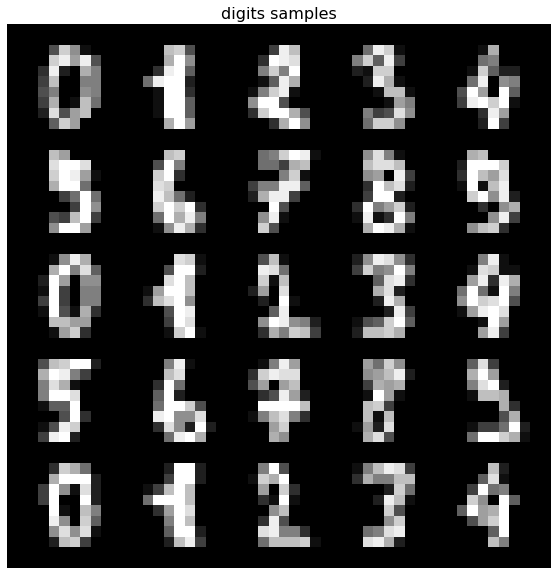

In [10]:
train_data, train_labels, test_data, test_labels = generate_digits_data(normalize=False)

show_samples(train_data[:25].reshape(-1,1, 8, 8)/16., 'digits samples', figsize=(10, 10))

In [11]:
OUTPUT_SEED = 0xBADBEEF

torch.manual_seed(OUTPUT_SEED)
np.random.seed(OUTPUT_SEED)

In [12]:
USE_CUDA=True

  0%|          | 0/400 [00:00<?, ?it/s]

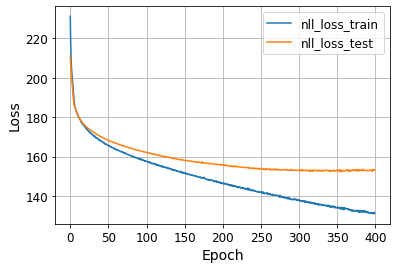

In [13]:
BATCH_SIZE = 1024 # any adequate value
EPOCHS = 400
LR = 1e-3

NUM_FLOWS = 12
DIM = 64


loader_args = dict(batch_size=BATCH_SIZE, shuffle=True)
train_loader = data.DataLoader(train_data, **loader_args)
test_loader = data.DataLoader(test_data, **loader_args)

# model
model = IDF([128, 128], NUM_FLOWS, DIM).to(DEVICE)

# train
train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='nll_loss', use_cuda=USE_CUDA, use_tqdm=True
)
plot_training_curves(train_losses, test_losses)

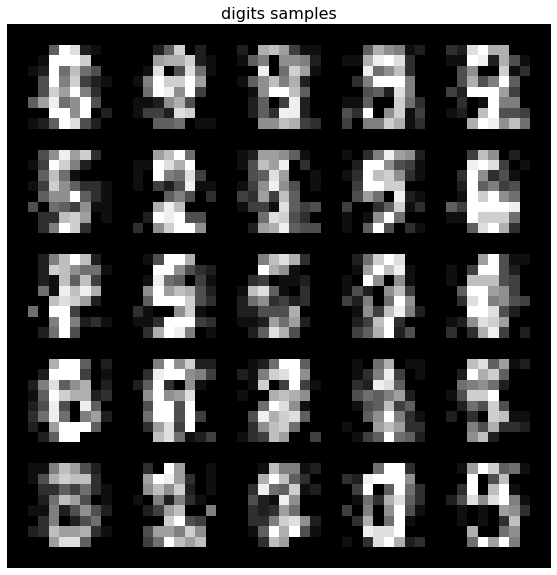

In [14]:
x = model.sample(25).detach().cpu().numpy()
x = x.clip(0., 16.)/16.
show_samples(x.reshape(-1, 1, 8, 8), 'digits samples', figsize=(10, 10))